In [67]:
import pandas as pd
from pathlib import Path
"counterfactual_results/nf=300_fl=24_nt=10_nt=30_ne=5_kt=0.33_re=False_gemma-2-9b"
"counterfactual_results/nf=300_fl=32_nt=10_nt=30_ne=5_kt=0.5_re=False_gemma-2-9b/generations_scores.json"
kl_path_format = "counterfactual_results/nf={n_feats}_fl={feat_layer}_nt={n_train}_nt={n_test}_ne={n_explanations}_kt={kl_threshold}_re={random_explanations}_l={latents}_{model_last}"
zero_ablation_path_format = "counterfactual_results/nf={n_feats}_fl={feat_layer}_nt={n_train}_nt={n_test}_ne={n_explanations}_re={random_explanations}_l={latents}_za={zero_ablate}_{model_last}"

base_cfg = {
    "feat_layer": 32,
    "n_feats": 300,
    "n_train": 10,
    "n_test": 30,
    "n_explanations": 5,
    "kl_threshold": 1.0,
    "random_explanations": False,
    "model_last": "gemma-2-9b",
    "latents": "sae",
    "zero_ablate": False
}

# load all results
def load_result(cfg):
    if cfg["zero_ablate"]:
        path = zero_ablation_path_format.format(**cfg)
    else:
        path = kl_path_format.format(**cfg)
    
    path = Path(path) / "generations_scores.json"
    try:
        df = pd.read_json(path)
    except FileNotFoundError as e:
        # rename "generations.json" to "partial_generations.json"
        path = path.parent / "generations.json"
        if path.exists():
            path.rename(path.parent / "partial_generations.json")
            print(f"Renamed {path} to {path.parent / 'partial_generations.json'}")
        raise e
    df = df.sort_values(by="max_delta_conditional_entropy", ascending=False)
    return df
base_df = load_result(base_cfg)
base_df

,intervention_strength,avg_kl,feat_idx,scorer_examples,completions,explainer_intervention_examples,explainer_examples,explanations,explainer_prompts,neuron_prompter,delta_conditional_entropy_by_explanation,delta_conditional_entropy_sems_by_explanation,max_delta_conditional_entropy,best_explanation
152,346.208872,1.093298,220,"[<bos> flags for a dollar, <bos>.Cost Details:...","[{'text': ' flags for a dollar', 'max_act': 13...",[{'prompt': ' the required permits before ente...,[<bos> the required permits before entering th...,"[extra, extra and additional, also charge, fee...",[ the required permits before entering the par...,"{'explanation': None, 'intervention_examples':...","{'extra': 1.6084987005, 'extra and additional,...","{'extra': 0.3860390506, 'extra and additional,...",3.793600,"extra and additional, also charge, fee, and up."
109,386.867563,0.931283,157,"[<bos>, Sports, Sports News Copyright © 2013 b...","[{'text': ', Sports, Sports News Copyright © 2...","[{'prompt': ' Record\nUnfortunately, the track...","[<bos> Record\nUnfortunately, the track record...","[reputation, reputation, reputation, reputatio...","[ Record\nUnfortunately, the track record for ...","{'explanation': None, 'intervention_examples':...",{'reputation': 3.4590745449},{'reputation': 0.7899054092000001},3.459075,reputation
162,251.227243,1.043937,231,"[<bos>\n""There is one huge limitation though: ...","[{'text': ' ""There is one huge limitation thou...","[{'prompt': ' as we drifted off, the silence o...","[<bos> as we drifted off, the silence of the h...","[by, naturally, in, out, and other words that ...","[ as we drifted off, the silence of the hours ...","{'explanation': None, 'intervention_examples':...","{'by, naturally, in, out, and other words that...","{'by, naturally, in, out, and other words that...",3.121144,"by, naturally, in, out, and other words that d..."
207,398.298434,0.946446,293,"[<bos> sauce. Not having burnt ends, <bos>Nati...","[{'text': ' sauce. Not having burnt ends', 'ma...",[{'prompt': ' sweet little preschool student. ...,[<bos> sweet little preschool student. Was it ...,"[leftovers, leftovers, food, and cooking, left...",[ sweet little preschool student. Was it a hin...,"{'explanation': None, 'intervention_examples':...","{'leftovers': 2.4942771316, 'leftovers, food, ...","{'leftovers': 0.6086200468, 'leftovers, food, ...",2.494277,leftovers
76,178.567651,1.066774,112,[<bos> thinners') such as warfarin (Coumadin);...,[{'text': ' thinners') such as warfarin (Couma...,"[{'prompt': ' Middle Eastern, Mexican, Indian,...","[<bos> Middle Eastern, Mexican, Indian, Chines...","[the word ""more"", more, much, many, so, even, ...","[ Middle Eastern, Mexican, Indian, Chinese, Vi...","{'explanation': None, 'intervention_examples':...","{'the word ""more""': 2.4673665365, 'more, much,...","{'the word ""more""': 0.4781815877, 'more, much,...",2.467367,"the word ""more"""
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,1139.941805,1.091643,59,[<bos> is first rate in both formats on my ref...,[{'text': ' is first rate in both formats on m...,"[{'prompt': '10/201405/10/2014Flight W6 8010, ...","[<bos>10/201405/10/2014Flight W6 8010, departu...","[metal, metal, music, maker, metal, and Normda...","[10/201405/10/2014Flight W6 8010, departure:07...","{'explanation': None, 'intervention_examples':...","{'metal': -0.1152374268, 'metal, music, maker,...","{'metal': 0.0813862382, 'metal, music, maker, ...",-0.115237,metal
36,627.567238,0.972196,52,"[<bos>.A., Wu, Y. 2005. Dilute acid pretreatme...","[{'text': '.A., Wu, Y. 2005. Dilute acid pretr...",[{'prompt': '/TAES.2013.6558046. ISSN 0018-92'...,"[<bos>/TAES.2013.6558046. ISSN 0018-92, <bos>\...","[chemicals, chemistry, engineering, and physic...","[/TAES.2013.6558046. ISSN 0018-92, \nreclassif...","{'explanation': None, 'intervention_examples':...","{'chemicals': -0.3312750578, 'chemistry, engin...","{'chemicals': 0.30026455620000003, 'chemistry,...",-0.119009,chemical engi

In [26]:
base_df.iloc[0].completions

[{'text': ' flags for a dollar',
  'max_act': 13.5625,
  'completions': {'clean': " flags for a dollar a hundred, and I've done",
   'intervened': ' flags for a dollar extra. The 2-star Hotel'}},
 {'text': '.Cost Details: This',
  'max_act': 11.5625,
  'completions': {'clean': '.Cost Details: This is a non-refunds package.',
   'intervened': '.Cost Details: This is the cost per month (P/'}},
 {'text': '60x91cm approx) poster down to an 8x10inch (20x25cm approx) photographic print. There is',
  'max_act': 10.8125,
  'completions': {'clean': '60x91cm approx) poster down to an 8x10inch (20x25cm approx) photographic print. There is a large gap at the top. I',
   'intervened': '60x91cm approx) poster down to an 8x10inch (20x25cm approx) photographic print. There is an extra cost of £1.9'}},
 {'text': ' Obsolete Man," and "A Quality',
  'max_act': 10.4375,
  'completions': {'clean': ' Obsolete Man," and "A Quality of Mercy." The first, filmed in',
   'intervened': ' Obsolete Man," and "A Qua

In [27]:
base_df.iloc[0].neuron_prompter


{'explanation': None,
 'intervention_examples': [{'prompt': ' the required permits before entering the park. Permits are available at the park headquarters and the convenience stores that you will pass on the way into the park.Camping Permits in addition to the entry permits are as',
   'top_p_increases': [0.3008865714,
    0.16157470640000002,
    0.09797129780000001,
    0.0316657014,
    0.0316140726],
   'top_tokens': [' an', ' extra', ' additional', ' nominal', ' a']},
  {'prompt': " in the mountainside, so that they blend in with nature. There is also a beach so you can swim in the sea, too. Negombo is a thermal pool park, and you don't need a reservation. You can just show up, pay the",
   'top_p_increases': [0.3283436894,
    0.1714348644,
    0.0732749701,
    0.027853250500000003,
    0.017171056900000002],
   'top_tokens': [' extra', ' fee', ' additional', ' small', ' charge']},
  {'prompt': ', if the website is to be used for marketing purposes, then there is',
   'top_p_in

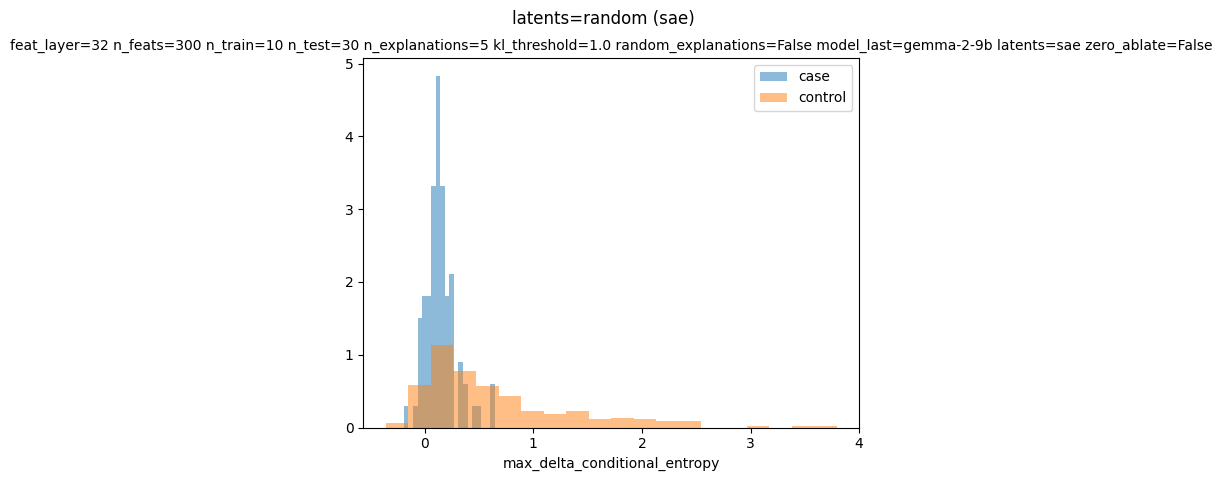

In [28]:
import matplotlib.pyplot as plt

cfg = base_cfg.copy()
case_cfg = base_cfg.copy()
# case_cfg["feat_layer"] = 41
case_cfg["latents"] = "random"

case_df = load_result(case_cfg)
cfg_df = load_result(cfg)

case_scores = case_df["max_delta_conditional_entropy"].values
cfg_scores = cfg_df["max_delta_conditional_entropy"].values

diff_keys = [k for k in case_cfg.keys() if case_cfg[k] != cfg[k]]


suptitle = " ".join([f"{k}={case_cfg[k]} ({cfg[k]})" for k in diff_keys])
title = " ".join([f"{k}={v}" for k, v in cfg.items()])
plt.hist(case_scores, bins=20, alpha=0.5, label="case", density=True)
plt.hist(cfg_scores, bins=20, alpha=0.5, label="control", density=True)
plt.suptitle(suptitle)
plt.title(title, fontsize=10)
plt.xlabel("max_delta_conditional_entropy")
plt.legend()
plt.show()



In [29]:
import pandas as pd

import json
path = "counterfactual_results/gpaolo_l32_input_scores.json"
with open(path, "r") as f:
    data = json.load(f)

input_df = pd.DataFrame([{"feat_idx": int(k.split("feature")[-1]), "feat": k, "score": data[k]["score"], "explanations": data[k]["explanations"]} for k in data.keys()])
input_df.head()

,feat_idx,feat,score,explanations
0,226,.model.layers.32_feature226,0.965000,Temporal adverb indicating a future point in t...
1,41,.model.layers.32_feature41,0.964181,"Adverbial or existential ""there"" typically use..."
2,345,.model.layers.32_feature345,0.963727,"Hyperlinks and web references, often denoted a..."
3,285,.model.layers.32_feature285,0.963542,Interrogative sentences starting with the word...
4,85,.model.layers.32_feature85,0.959737,"Periods at the end of website URLs, publicatio..."


In [30]:
# plots I want:
# score vs layer at each KL thresh and zero-ablation (show avg kl div)
# "" for random sae
# "" for random explanations
# output score vs input score for l32, for each KL thresh and zero-ablation

File not found for {'feat_layer': 8, 'n_feats': 300, 'n_train': 10, 'n_test': 30, 'n_explanations': 5, 'kl_threshold': 0.33, 'random_explanations': True, 'model_last': 'gemma-2-9b', 'latents': 'sae', 'zero_ablate': False}: File counterfactual_results/nf=300_fl=8_nt=10_nt=30_ne=5_kt=0.33_re=True_l=sae_gemma-2-9b/generations_scores.json does not exist
Renamed counterfactual_results/nf=300_fl=16_nt=10_nt=30_ne=5_kt=0.33_re=True_l=sae_gemma-2-9b/generations.json to counterfactual_results/nf=300_fl=16_nt=10_nt=30_ne=5_kt=0.33_re=True_l=sae_gemma-2-9b/partial_generations.json
File not found for {'feat_layer': 16, 'n_feats': 300, 'n_train': 10, 'n_test': 30, 'n_explanations': 5, 'kl_threshold': 0.33, 'random_explanations': True, 'model_last': 'gemma-2-9b', 'latents': 'sae', 'zero_ablate': False}: File counterfactual_results/nf=300_fl=16_nt=10_nt=30_ne=5_kt=0.33_re=True_l=sae_gemma-2-9b/generations_scores.json does not exist
Renamed counterfactual_results/nf=300_fl=24_nt=10_nt=30_ne=5_kt=0.33_

/home/alex/.conda/envs/autointerp/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.conda/envs/autointerp/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


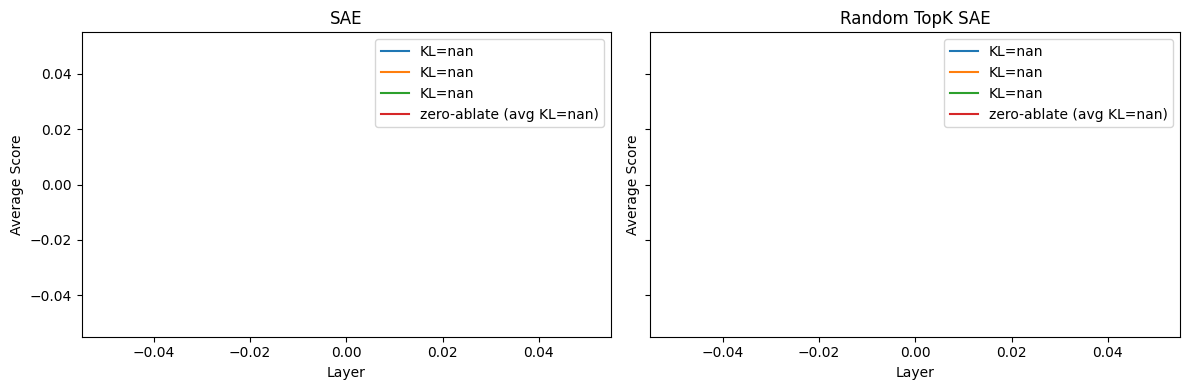

In [68]:
import numpy as np

# Score vs Layer at each KL threshold and zero-ablation
kl_thresholds = [0.33, 1.0, 3.0, None]
layers = [8, 16, 24, 32, 40, 41]

fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for i, latents in enumerate(["sae", "random"]):
    plt.sca(axs[i])
    for kl in kl_thresholds:
        used_layers = []
        avg_scores = []
        avg_kls = []
        for feat_layer in layers:
            cfg = base_cfg.copy()
            cfg["feat_layer"] = feat_layer
            if kl is None:    
                cfg["zero_ablate"] = True
            else:
                cfg["kl_threshold"] = kl
            cfg["latents"] = latents
            cfg["random_explanations"] = True
            try:
                df = load_result(cfg)
            except FileNotFoundError as e:
                print(f"File not found for {cfg}: {e}")
                continue
            avg_kls.append(df['avg_kl'].values.mean())
            avg_scores.append(df['max_delta_conditional_entropy'].values.mean())
            used_layers.append(feat_layer)
        label = f"zero-ablate (avg KL={np.mean(avg_kls):.2f})" if kl is None else f"KL={np.mean(avg_kls):.2f}"
        plt.plot(used_layers, avg_scores, label=label)
        plt.scatter(used_layers, avg_scores)
    plt.xlabel('Layer')
    plt.ylabel('Average Score')
    plt.legend()
    plt.title("SAE" if latents == "sae" else "Random TopK SAE")
plt.tight_layout()
plt.show()

In [40]:
!pip install scipy

  Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.2 MB)


LinregressResult(slope=np.float64(-0.8972404452260677), intercept=np.float64(1.0373501075574736), rvalue=np.float64(-0.28458253186982885), pvalue=np.float64(2.9646437666686262e-05), stderr=np.float64(0.2100758873266564), intercept_stderr=np.float64(0.1596096438239074))


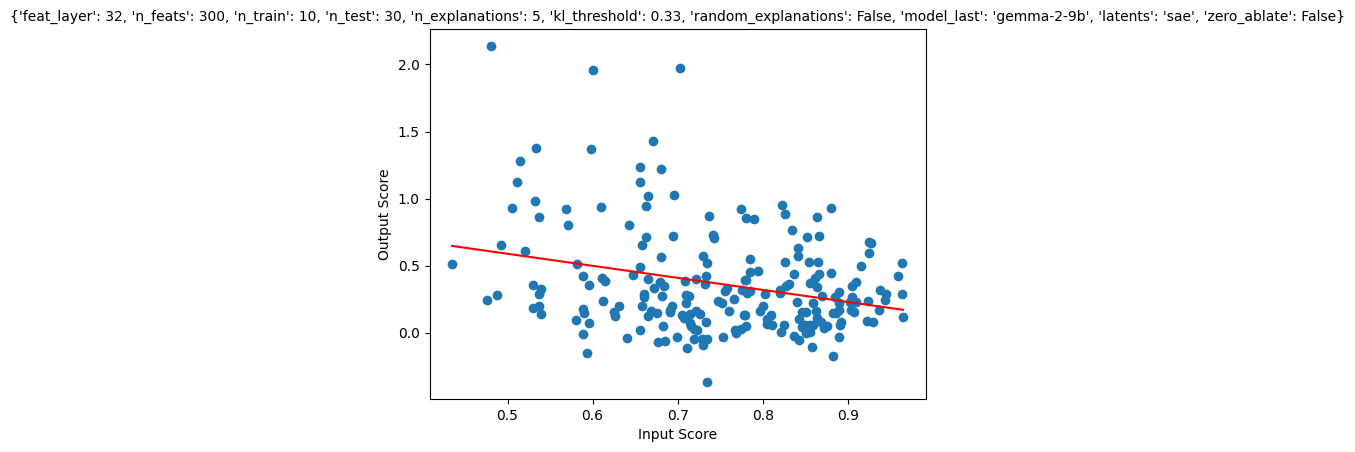

In [52]:
from scipy.stats import linregress

kl_thresh = 0.33
cfg = base_cfg.copy()
if kl_thresh is None:
    cfg["zero_ablate"] = True
else:
    cfg["kl_threshold"] = kl_thresh
cfg
df = load_result(cfg)

joined_df = input_df.merge(df, on="feat_idx")

linr = linregress(joined_df["score"], joined_df["max_delta_conditional_entropy"])
print(linr)
plt.figure()
plt.title(cfg, fontsize=10)
plt.scatter(joined_df["score"], joined_df["max_delta_conditional_entropy"])
plt.plot(joined_df["score"], linr.intercept + linr.slope * joined_df["score"], color="red")
plt.xlabel("Input Score")
plt.ylabel("Output Score")
plt.show()
